## About this API process

100 articles related to the brain tumor microenvironment (TME) will be gathered using the Semantic Scholar API. This API allows quick retreival of metadata for scientific publications.

The goal of using this API is to analyze abstracts from recent publications on the brain TME to gain insights into recent developments and trends in the fields.

Datasets can also be downloaded from publications using the Semantic Scholar API. So, if articles of interest are identified from the original GET, specific data will be pulled and analyzed further.

In [42]:
## import necessary packages
import os
from requests import Session
from requests.adapters import HTTPAdapter
from urllib3.util import Retry
import json
import re  #regular expressions
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer   
#for text vectorization

import nltk
from nltk.corpus import stopwords

In [31]:
# Define the search query and filters
query = "brain tumor microenvironment"
fields = "paperId,title,year,authors,fieldsOfStudy,abstract,url"
limit =100  # Fetch up to 1000 papers in one request
publication_types = "JournalArticle,Review,ClinicalTrial"  # Filter by publication types
fields_of_study = "Medicine,Public Health,Chemistry,Biology"  # Filter by fields of study
year = "2020-2023"  # Papers published between 2020 and 2023

http = Session()

request = http.get(
    "https://api.semanticscholar.org/graph/v1/paper/search",
    params={
        'query': query,
        'fields': fields,
        'limit': limit,
        'publicationTypes': publication_types,
        'fieldsOfStudy': fields_of_study,
        'year': year
    }
)

print(request.url)
request.raise_for_status()  # Ensures we stop if there's an error
jsontxt = request.json()


## Create a new csv file to save the headlines
filename="tme_abstracts.csv"


my_file=open(filename,"w")
### Place the column names in - write to the first row
write_this="paper id,year,title,abstract,url\n"
my_file.write(write_this)
my_file.close()


## Open the file for append
my_file=open(filename, "a")

## Go through the json text:
for items in jsontxt["data"]:

    id=items["paperId"]
    
    year=items["year"]
    
    ## CLEAN the Title
  
    title=items["title"]
    title=re.sub(r'[^a-zA-Z]', " ", title, flags=re.VERBOSE)
    title=' '.join(title.split())
    title=re.sub("\n|\r", "", title)
    # ##----------------------------------------------------------
    
    abstract=items["abstract"]
    if abstract != None:
        abstract=re.sub(r'[^a-zA-Z]', " ", abstract, flags=re.VERBOSE)
        abstract=abstract.replace(',', '')
        abstract=' '.join(abstract.split())
        abstract=re.sub("\n|\r", "", abstract)

    url=items["url"]
    
    
    write_this=str(id)+","+ str(year)+","+ str(title)+","+ str(abstract) + "," + str(url) + "\n"
    
    my_file.write(write_this)
    
## CLOSE THE FILE
my_file.close()


https://api.semanticscholar.org/graph/v1/paper/search?query=brain+tumor+microenvironment&fields=paperId%2Ctitle%2Cyear%2Cauthors%2CfieldsOfStudy%2Cabstract%2Curl&limit=100&publicationTypes=JournalArticle%2CReview%2CClinicalTrial&fieldsOfStudy=Medicine%2CPublic+Health%2CChemistry%2CBiology&year=2020-2023


In [45]:
## tokenize and vectorize abstracts
## Read to DF
abstract_df=pd.read_csv(filename, on_bad_lines= 'skip')
#print(abstract_df.head())

# iterating the columns 
#for col in abstract_df.columns: 
     #print(col) 
    
abstract_df = abstract_df.dropna()
#print(abstract_df["abstract"])


### Tokenize and Vectorize the Headlines
## Create the list of headlines
abstract_list=[]
for next in abstract_df["abstract"]:
     abstract_list.append(next)

print("The abstract list is")
print(abstract_list)


## Vectorize
# ## Read about CountVectorizer here.....
# #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

my_count_v=CountVectorizer(
     input="content", 
     lowercase=True, 
     stop_words = "english"
     )
 
vectorized_abstract_df = my_count_v.fit_transform(abstract_list)  # create a sparse matrix
#print(type(vectorized_abstract_df))
#vocab is a vocabulary list
vocab = my_count_v.get_feature_names_out()  # change to a list
#print(list(vocab)[10:20])

vectorized_abstract_df = vectorized_abstract_df.toarray()  # convert to a regular array
#print(type(vectorized_abstract_df))

column_names=my_count_v.get_feature_names_out()
vectorized_abstract_df=pd.DataFrame(vectorized_abstract_df,columns=column_names)


nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for col in vectorized_abstract_df:
     if col in stop_words:
          vectorized_abstract_df.drop(col, inplace=True, axis=1)

print(vectorized_abstract_df)


#vectorized_abstract_df.to_csv("tme_vectorized_abstracts.csv", index=False)

The abstract list is
['Malignant brain tumors lack effective treatment that can improve their poor overall survival achieved with standard of care Advancement in different cancer treatments has shifted the focus in brain tumor research and clinical trials toward immunotherapy based approaches The investigation of the immune cell landscape revealed a dominance of myeloid cells in the tumor microenvironment Their exact roles and functions are the subject of ongoing research Current evidence suggests a complex interplay of tumor cells and myeloid cells with competing functions toward support vs control of tumor growth', 'Simple Summary Pediatric brain tumors are unique from adult tumors and pose challenges due to their distinct characteristics including differences in tumor immunology molecular profiles and response to various treatments Understanding these differences is crucial for developing targeted and effective therapeutic strategies This review delves into our current understanding

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianazweng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tumor        306
cells        228
brain        227
cell         143
immune       139
            ... 
various       17
important     17
vivo          17
liver         17
data          17
Length: 100, dtype: int64


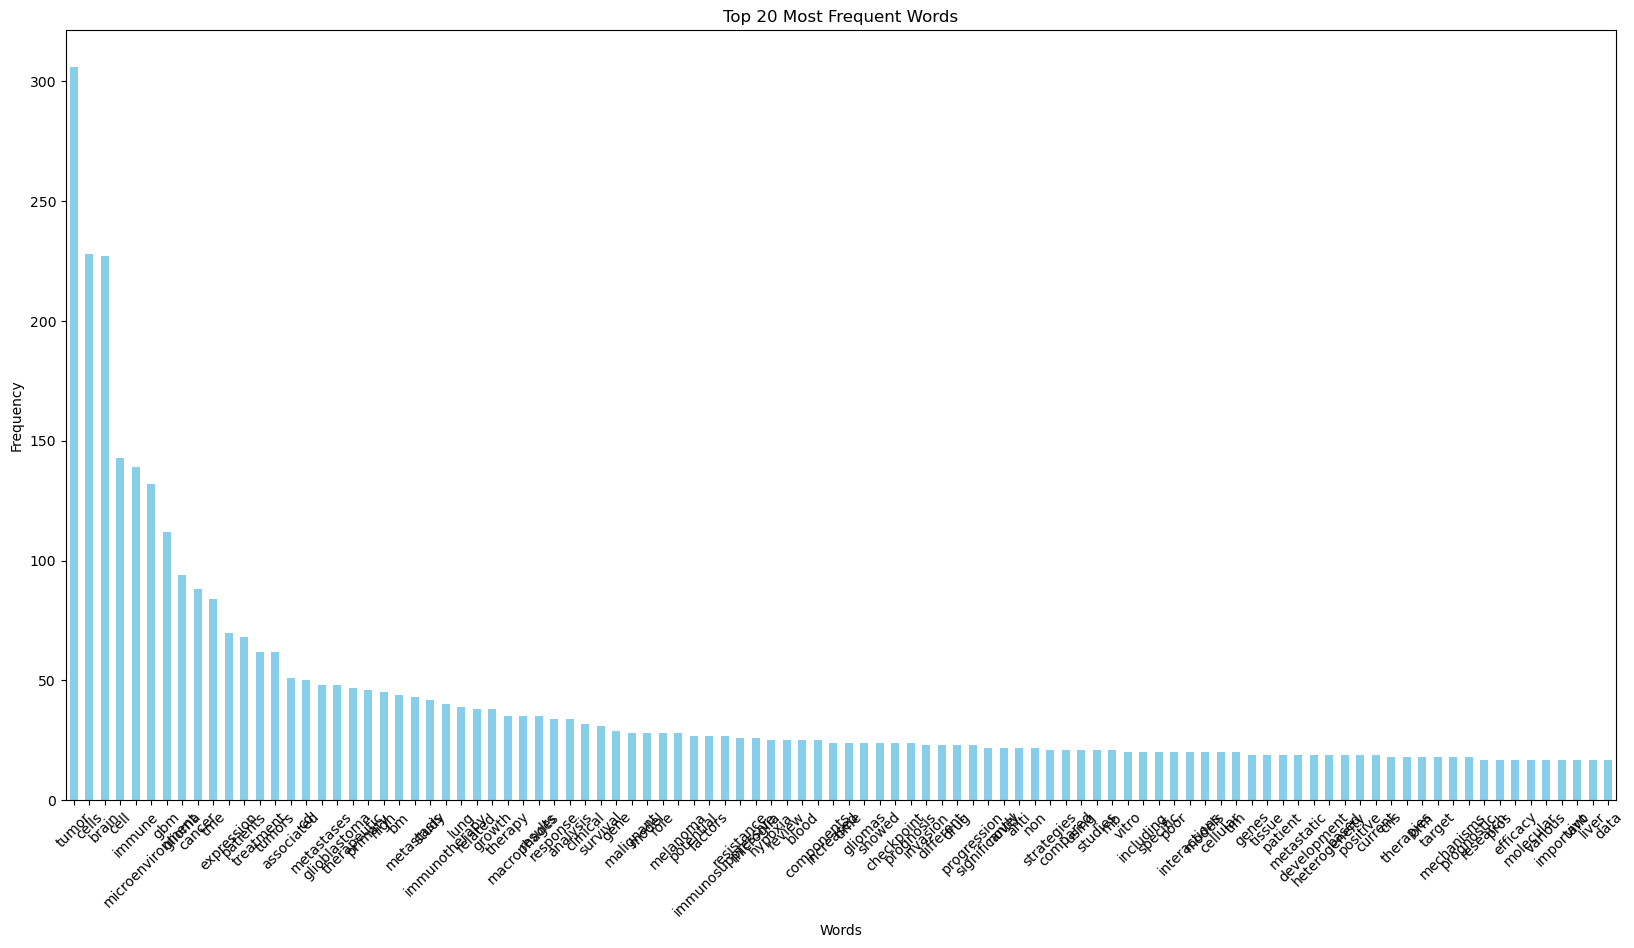

In [50]:
import matplotlib.pyplot as plt 
word_frequencies = vectorized_abstract_df.sum(axis=0)

sorted_word_frequencies = word_frequencies.sort_values(ascending=False)

# Select the top 20 most frequent words
top_20_words = sorted_word_frequencies.head(100)

print(top_20_words)

# Plot the top 20 most frequent words
plt.figure(figsize=(20, 10))
top_20_words.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()